# Imagenet - RMS Prop Optimizer

|S.No.|Optimization|Architecture|Pretrained|Pre-processing|Batch Count|Epochs|Loss Function|Optimizer|LR|Scheduler|Time per epoch|Test Acc|Val Acc|Overfitting| Underfitting|
|--|--|--|--|--|--|--|--|--|--|--|--|--|--|--|--|
|1|Basic|Resnet50|No|Convert To Tensor|128|30|CrossEntropyLoss|SGD|None|0.05|1.30|99.84|68.33|Yes|No|
|2|Resize Image|Resnet50|No|Resize Image|128|30|CrossEntropyLoss|SGD|None|0.05|1.30|99.86|69.89|Yes|No|
|3|Normalized Image|Resnet50|No|Normalized Image|128|30|CrossEntropyLoss|SGD|None|0.05|1.30|99.89|70.34|Yes|No|
|4|LR 0.001|Resnet50|No|Normalized Image|128|30|CrossEntropyLoss|SGD|None|0.001|1.30|80.27|69.88|Yes|No|
|5|LR 0.001 --> 0.0001/10|Resnet50|No|Normalized Image|128|30|CrossEntropyLoss|SGD|None|0.001/0.0001|1.30|68.15|65.15|Yes|No|
|6|Adam Optimizer|Resnet50|No|Normalized Image|128|30|CrossEntropyLoss|Adam|None|0.001/0.0001|1.30|99.14|58.27|Yes|No|
|7|RMSProp Optimizer|Resnet50|No|Normalized Image|128|30|CrossEntropyLoss|RMSProp|None|0.001/0.0001|1.30|99.14|58.27|Yes|No|

## Summary
- Overall Val accuracy has been reduced to 58.27%
- Adam optimizer lead to overfitting in the first 5 epochs 


## Install Packages

In [1]:
!pip3 install torch torchvision --index-url https://download.pytorch.org/whl/cu118 # Install packages in the correct order
!pip install numpy==1.24.3
!pip install tqdm matplotlib pillow
!pip install seaborn scikit-learn

Looking in indexes: https://download.pytorch.org/whl/cu118


## Check for CUDA and set device

In [2]:
# Verify CUDA availability
import torch
print(f"PyTorch version: {torch.__version__}")
print(f"CUDA available: {torch.cuda.is_available()}")
if torch.cuda.is_available():
    print(f"CUDA device: {torch.cuda.get_device_name(0)}")
    
# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

PyTorch version: 2.4.1+cu118
CUDA available: True
CUDA device: Tesla T4
Using device: cuda


## Import all packages

In [3]:
# Import all required libraries
import os
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
from torchvision.datasets import ImageFolder
import matplotlib.pyplot as plt
import time
from tqdm import tqdm
import urllib.request
import zipfile
import shutil

## Verify installation and important package versions

In [4]:
# Verify installations
import numpy as np
print(f"Numpy version: {np.__version__}")

import torch
print(f"PyTorch version: {torch.__version__}")

import torchvision
print(f"Torchvision version: {torchvision.__version__}")

Numpy version: 1.24.3
PyTorch version: 2.4.1+cu118
Torchvision version: 0.19.1+cu118


In [5]:
## Application Constants
BATCH_SIZE = 128
NUM_CLASSES = 200
EPOCHS_COUNT = 30
LR = 0.001

## Download Dataset

In [6]:
# Download and extract Tiny ImageNet
def download_and_extract_tiny_imagenet():
    url = "http://cs231n.stanford.edu/tiny-imagenet-200.zip"
    zip_path = "tiny-imagenet-200.zip"
    extract_path = "tiny-imagenet-200"
    
    if not os.path.exists(extract_path):
        print("Downloading Tiny ImageNet...")
        urllib.request.urlretrieve(url, zip_path)
        
        print("Extracting files...")
        with zipfile.ZipFile(zip_path, 'r') as zip_ref:
            zip_ref.extractall("./")
        
        # Remove the zip file
        os.remove(zip_path)
        print("Dataset ready!")
    else:
        print("Dataset already exists!")
    
    return extract_path

In [7]:
# Prepare validation directory structure
def restructure_val_dir(dataset_path):
    val_dir = os.path.join(dataset_path, 'val')
    val_images_dir = os.path.join(val_dir, 'images')
    
    if os.path.exists(val_images_dir):
        # Read validation annotations file
        val_annotations_file = os.path.join(val_dir, 'val_annotations.txt')
        with open(val_annotations_file, 'r') as f:
            val_annotations = f.readlines()
        
        # Create class directories and move images
        for line in val_annotations:
            parts = line.strip().split('\t')
            img_name, class_id = parts[0], parts[1]
            
            # Create class directory if it doesn't exist
            class_dir = os.path.join(val_dir, class_id)
            os.makedirs(class_dir, exist_ok=True)
            
            # Move image to class directory
            src_path = os.path.join(val_images_dir, img_name)
            dst_path = os.path.join(class_dir, img_name)
            if os.path.exists(src_path):
                shutil.move(src_path, dst_path)
        
        # Remove the original images directory and annotations file
        shutil.rmtree(val_images_dir)
        os.remove(val_annotations_file)

In [8]:
# Download and prepare dataset
dataset_path = download_and_extract_tiny_imagenet()
restructure_val_dir(dataset_path)

Dataset already exists!


## Define Transformations

In [9]:
# Define data transforms
train_transform = transforms.Compose([
    transforms.Resize((64, 64)),  # Tiny ImageNet images are 64x64
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

val_transform = transforms.Compose([
    transforms.Resize((64, 64)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

## Prepare Dataset

In [10]:
# Load datasets
train_dir = os.path.join(dataset_path, 'train')
val_dir = os.path.join(dataset_path, 'val')

train_dataset = ImageFolder(train_dir, transform=train_transform)
val_dataset = ImageFolder(val_dir, transform=val_transform)


In [11]:
# Create data loaders
batch_size = BATCH_SIZE  # Increased batch size
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=4, pin_memory=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=4, pin_memory=True)


## Load Resnet50 Model

In [12]:
# Load ResNet50 with pretrained=False for training from scratch
model = torchvision.models.resnet50(weights='ResNet50_Weights.DEFAULT')
num_classes = NUM_CLASSES
model.fc = nn.Linear(model.fc.in_features, num_classes)
model = model.to(device)


## Define Loss Function and Optimizer

In [13]:
# Define loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.RMSprop(model.parameters(), lr=LR)

## Train the model

In [14]:
# Training function
def train_epoch(model, train_loader, criterion, optimizer):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0
    
    pbar = tqdm(train_loader, desc='Training')
    for inputs, labels in tqdm(train_loader, desc="Training"):
        inputs, labels = inputs.to(device), labels.to(device)
        
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
        _, predicted = outputs.max(1)
        total += labels.size(0)
        correct += predicted.eq(labels).sum().item()
    
    epoch_loss = running_loss / len(train_loader)
    epoch_acc = 100. * correct / total
    return epoch_loss, epoch_acc


In [15]:
# Validation function
def validate(model, val_loader, criterion):
    model.eval()
    running_loss = 0.0
    correct = 0
    total = 0
    
    with torch.no_grad():
        for inputs, labels in tqdm(val_loader, desc="Validation"):
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            
            running_loss += loss.item()
            _, predicted = outputs.max(1)
            total += labels.size(0)
            correct += predicted.eq(labels).sum().item()
    
    epoch_loss = running_loss / len(val_loader)
    epoch_acc = 100. * correct / total
    return epoch_loss, epoch_acc


In [16]:
# Training loop
num_epochs = EPOCHS_COUNT
train_losses = []
train_accs = []
val_losses = []
val_accs = []

for epoch in range(num_epochs):
    print(f"\nEpoch {epoch+1}/{num_epochs}")
    
    # Change LR 0.001 to 0.0001 after 10 epoch
    if epoch+1 > 10:
        optimizer = optim.RMSprop(model.parameters(), lr=0.0001)

    # Train
    train_loss, train_acc = train_epoch(model, train_loader, criterion, optimizer)
    train_losses.append(train_loss)
    train_accs.append(train_acc)
    
    # Validate
    val_loss, val_acc = validate(model, val_loader, criterion)
    val_losses.append(val_loss)
    val_accs.append(val_acc)
    
    print(f"Train Loss: {train_loss:.4f} | Train Acc: {train_acc:.2f}%")
    print(f"Val Loss: {val_loss:.4f} | Val Acc: {val_acc:.2f}%")



Epoch 1/30


Validation: 100%|██████████| 79/79 [00:03<00:00, 22.98it/s]


Train Loss: 4.2293 | Train Acc: 11.71%
Val Loss: 3.2313 | Val Acc: 24.76%

Epoch 2/30


Validation: 100%|██████████| 79/79 [00:03<00:00, 23.41it/s]


Train Loss: 2.6184 | Train Acc: 36.61%
Val Loss: 2.6729 | Val Acc: 36.38%

Epoch 3/30


Validation: 100%|██████████| 79/79 [00:03<00:00, 23.57it/s]


Train Loss: 1.9874 | Train Acc: 49.39%
Val Loss: 2.6907 | Val Acc: 37.33%

Epoch 4/30


Validation: 100%|██████████| 79/79 [00:03<00:00, 23.95it/s]


Train Loss: 1.4770 | Train Acc: 60.55%
Val Loss: 2.5666 | Val Acc: 41.84%

Epoch 5/30


Validation: 100%|██████████| 79/79 [00:03<00:00, 23.98it/s]


Train Loss: 1.0074 | Train Acc: 71.93%
Val Loss: 2.8760 | Val Acc: 40.30%

Epoch 6/30


Validation: 100%|██████████| 79/79 [00:03<00:00, 23.94it/s]


Train Loss: 0.6243 | Train Acc: 81.93%
Val Loss: 2.9200 | Val Acc: 42.53%

Epoch 7/30


Validation: 100%|██████████| 79/79 [00:03<00:00, 23.71it/s]


Train Loss: 0.3973 | Train Acc: 88.01%
Val Loss: 3.1439 | Val Acc: 43.00%

Epoch 8/30


Validation: 100%|██████████| 79/79 [00:03<00:00, 23.58it/s]


Train Loss: 0.2958 | Train Acc: 90.91%
Val Loss: 3.5384 | Val Acc: 40.44%

Epoch 9/30


Validation: 100%|██████████| 79/79 [00:03<00:00, 23.36it/s]


Train Loss: 0.2431 | Train Acc: 92.36%
Val Loss: 3.3939 | Val Acc: 43.87%

Epoch 10/30


Validation: 100%|██████████| 79/79 [00:03<00:00, 23.71it/s]


Train Loss: 0.2131 | Train Acc: 93.43%
Val Loss: 3.5047 | Val Acc: 44.36%

Epoch 11/30


Validation: 100%|██████████| 79/79 [00:03<00:00, 23.76it/s]


Train Loss: 0.0490 | Train Acc: 98.73%
Val Loss: 3.3436 | Val Acc: 49.08%

Epoch 12/30


Validation: 100%|██████████| 79/79 [00:03<00:00, 23.45it/s]


Train Loss: 0.0109 | Train Acc: 99.91%
Val Loss: 3.5378 | Val Acc: 48.94%

Epoch 13/30


Validation: 100%|██████████| 79/79 [00:03<00:00, 23.89it/s]


Train Loss: 0.0059 | Train Acc: 99.94%
Val Loss: 3.6960 | Val Acc: 49.34%

Epoch 14/30


Validation: 100%|██████████| 79/79 [00:03<00:00, 23.41it/s]


Train Loss: 0.0042 | Train Acc: 99.96%
Val Loss: 3.8111 | Val Acc: 49.47%

Epoch 15/30


Validation: 100%|██████████| 79/79 [00:03<00:00, 23.85it/s]


Train Loss: 0.0032 | Train Acc: 99.97%
Val Loss: 3.9598 | Val Acc: 49.84%

Epoch 16/30


Validation: 100%|██████████| 79/79 [00:03<00:00, 23.93it/s]


Train Loss: 0.0030 | Train Acc: 99.97%
Val Loss: 4.1163 | Val Acc: 49.25%

Epoch 17/30


Validation: 100%|██████████| 79/79 [00:03<00:00, 23.95it/s]


Train Loss: 0.0023 | Train Acc: 99.97%
Val Loss: 4.0799 | Val Acc: 49.86%

Epoch 18/30


Validation: 100%|██████████| 79/79 [00:03<00:00, 23.90it/s]


Train Loss: 0.0020 | Train Acc: 99.97%
Val Loss: 4.1723 | Val Acc: 49.97%

Epoch 19/30


Validation: 100%|██████████| 79/79 [00:03<00:00, 24.00it/s]


Train Loss: 0.0019 | Train Acc: 99.97%
Val Loss: 4.5939 | Val Acc: 48.79%

Epoch 20/30


Validation: 100%|██████████| 79/79 [00:03<00:00, 24.18it/s]


Train Loss: 0.0017 | Train Acc: 99.96%
Val Loss: 4.3886 | Val Acc: 49.59%

Epoch 21/30


Validation: 100%|██████████| 79/79 [00:03<00:00, 23.81it/s]


Train Loss: 0.0015 | Train Acc: 99.97%
Val Loss: 4.4446 | Val Acc: 49.71%

Epoch 22/30


Validation: 100%|██████████| 79/79 [00:03<00:00, 23.83it/s]


Train Loss: 0.0015 | Train Acc: 99.97%
Val Loss: 4.5791 | Val Acc: 49.34%

Epoch 23/30


Validation: 100%|██████████| 79/79 [00:03<00:00, 23.93it/s]


Train Loss: 0.0013 | Train Acc: 99.97%
Val Loss: 4.5715 | Val Acc: 49.77%

Epoch 24/30


Validation: 100%|██████████| 79/79 [00:03<00:00, 23.86it/s]


Train Loss: 0.0013 | Train Acc: 99.97%
Val Loss: 4.6330 | Val Acc: 49.52%

Epoch 25/30


Validation: 100%|██████████| 79/79 [00:03<00:00, 23.83it/s]


Train Loss: 0.0013 | Train Acc: 99.97%
Val Loss: 4.7281 | Val Acc: 48.97%

Epoch 26/30


Validation: 100%|██████████| 79/79 [00:03<00:00, 23.92it/s]


Train Loss: 0.0012 | Train Acc: 99.97%
Val Loss: 4.6637 | Val Acc: 50.20%

Epoch 27/30


Validation: 100%|██████████| 79/79 [00:03<00:00, 23.84it/s]


Train Loss: 0.0012 | Train Acc: 99.97%
Val Loss: 4.8178 | Val Acc: 49.51%

Epoch 28/30


Validation: 100%|██████████| 79/79 [00:03<00:00, 24.17it/s]


Train Loss: 0.0010 | Train Acc: 99.97%
Val Loss: 4.8176 | Val Acc: 49.64%

Epoch 29/30


Validation: 100%|██████████| 79/79 [00:03<00:00, 23.92it/s]


Train Loss: 0.0010 | Train Acc: 99.97%
Val Loss: 4.9318 | Val Acc: 49.29%

Epoch 30/30


Validation: 100%|██████████| 79/79 [00:03<00:00, 24.05it/s]

Train Loss: 0.0010 | Train Acc: 99.97%
Val Loss: 5.0689 | Val Acc: 49.80%


## Plot Metrics

In [17]:
# Plot training and validation metrics
plt.figure(figsize=(12, 4))

<Figure size 1200x400 with 0 Axes>

<Figure size 1200x400 with 0 Axes>

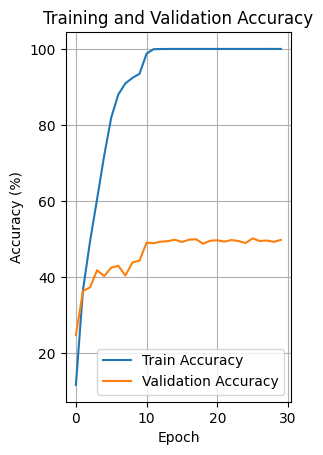

In [18]:
# Plot accuracy
plt.subplot(1, 2, 1)
plt.plot(train_accs, label='Train Accuracy')
plt.plot(val_accs, label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.title('Training and Validation Accuracy')
plt.legend()
plt.grid(True)

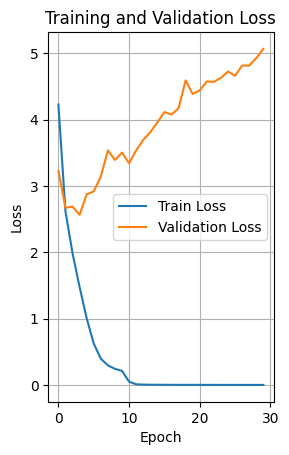

In [19]:
# Plot loss
plt.subplot(1, 2, 2)
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.grid(True)

In [20]:
plt.tight_layout()
plt.show()

<Figure size 640x480 with 0 Axes>

## Save Model

In [21]:
# Save the model
torch.save(model.state_dict(), 'resnet50_tiny_imagenet.pth')

## Plot Misclassified Images

In [22]:
def get_class_name_mapping(dataset_path):
    """
    Create mapping from wnid to human-readable class names using words.txt
    """
    words_file = os.path.join(dataset_path, 'words.txt')
    wnid_to_name = {}
    
    try:
        with open(words_file, 'r') as f:
            for line in f:
                wnid, names = line.strip().split('\t')
                # Take the first comma-separated name if multiple exist
                name = names.split(',')[0].strip()
                wnid_to_name[wnid] = name
    except FileNotFoundError:
        print(f"Warning: words.txt not found at {words_file}")
        # Create a simple mapping if words.txt is not available
        wnid_to_name = {class_id: class_id for class_id in train_dataset.classes}
    
    return wnid_to_name

In [23]:
def denormalize(tensor):
    """
    Denormalize the image tensor for visualization
    """
    mean = torch.tensor([0.485, 0.456, 0.406]).view(3, 1, 1)
    std = torch.tensor([0.229, 0.224, 0.225]).view(3, 1, 1)
    return tensor * std + mean

In [24]:
def get_misclassified_images(model, val_loader, class_mapping, num_images=20):
    """
    Get misclassified images with their true and predicted labels
    """
    model.eval()
    misclassified_images = []
    true_classes = []
    pred_classes = []
    
    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs, 1)
            
            # Find misclassified images
            mask = (predicted != labels)
            misclassified_idx = mask.nonzero(as_tuple=True)[0]
            
            for idx in misclassified_idx:
                if len(misclassified_images) >= num_images:
                    break
                
                # Get wnids
                true_wnid = train_dataset.classes[labels[idx].item()]
                pred_wnid = train_dataset.classes[predicted[idx].item()]
                
                # Get human-readable names
                true_class_name = class_mapping.get(true_wnid, true_wnid)
                pred_class_name = class_mapping.get(pred_wnid, pred_wnid)
                
                misclassified_images.append(images[idx].cpu())
                true_classes.append(true_class_name)
                pred_classes.append(pred_class_name)
                
            if len(misclassified_images) >= num_images:
                break
    
    return misclassified_images, true_classes, pred_classes

In [25]:
def plot_misclassified(images, true_classes, pred_classes, num_images=20):
    """
    Plot misclassified images in a grid
    """
    if len(images) < num_images:
        num_images = len(images)
    
    num_rows = (num_images + 4) // 5  # 5 images per row
    fig, axes = plt.subplots(num_rows, 5, figsize=(20, 4*num_rows))
    axes = axes.ravel()
    
    for idx in range(num_images):
        # img = denormalize(images[idx])
        img = images[idx]
        img = torch.clamp(img, 0, 1)
        
        # Format class names
        true_class = true_classes[idx]
        pred_class = pred_classes[idx]
        
        # Truncate long class names
        true_display = true_class[:25] + '...' if len(true_class) > 25 else true_class
        pred_display = pred_class[:25] + '...' if len(pred_class) > 25 else pred_class
        
        axes[idx].imshow(img.permute(1, 2, 0))
        axes[idx].axis('off')
        title = f'True: {true_display}\nPred: {pred_display}'
        axes[idx].set_title(title, fontsize=10, color='red', pad=10)
    
    # Turn off any unused subplots
    for idx in range(num_images, len(axes)):
        axes[idx].axis('off')
    
    plt.tight_layout()
    plt.show()

In [26]:
# Get class name mapping
class_mapping = get_class_name_mapping(dataset_path)

In [27]:
# Get misclassified images
misclassified_images, true_classes, pred_classes = get_misclassified_images(
    model, val_loader, class_mapping
)

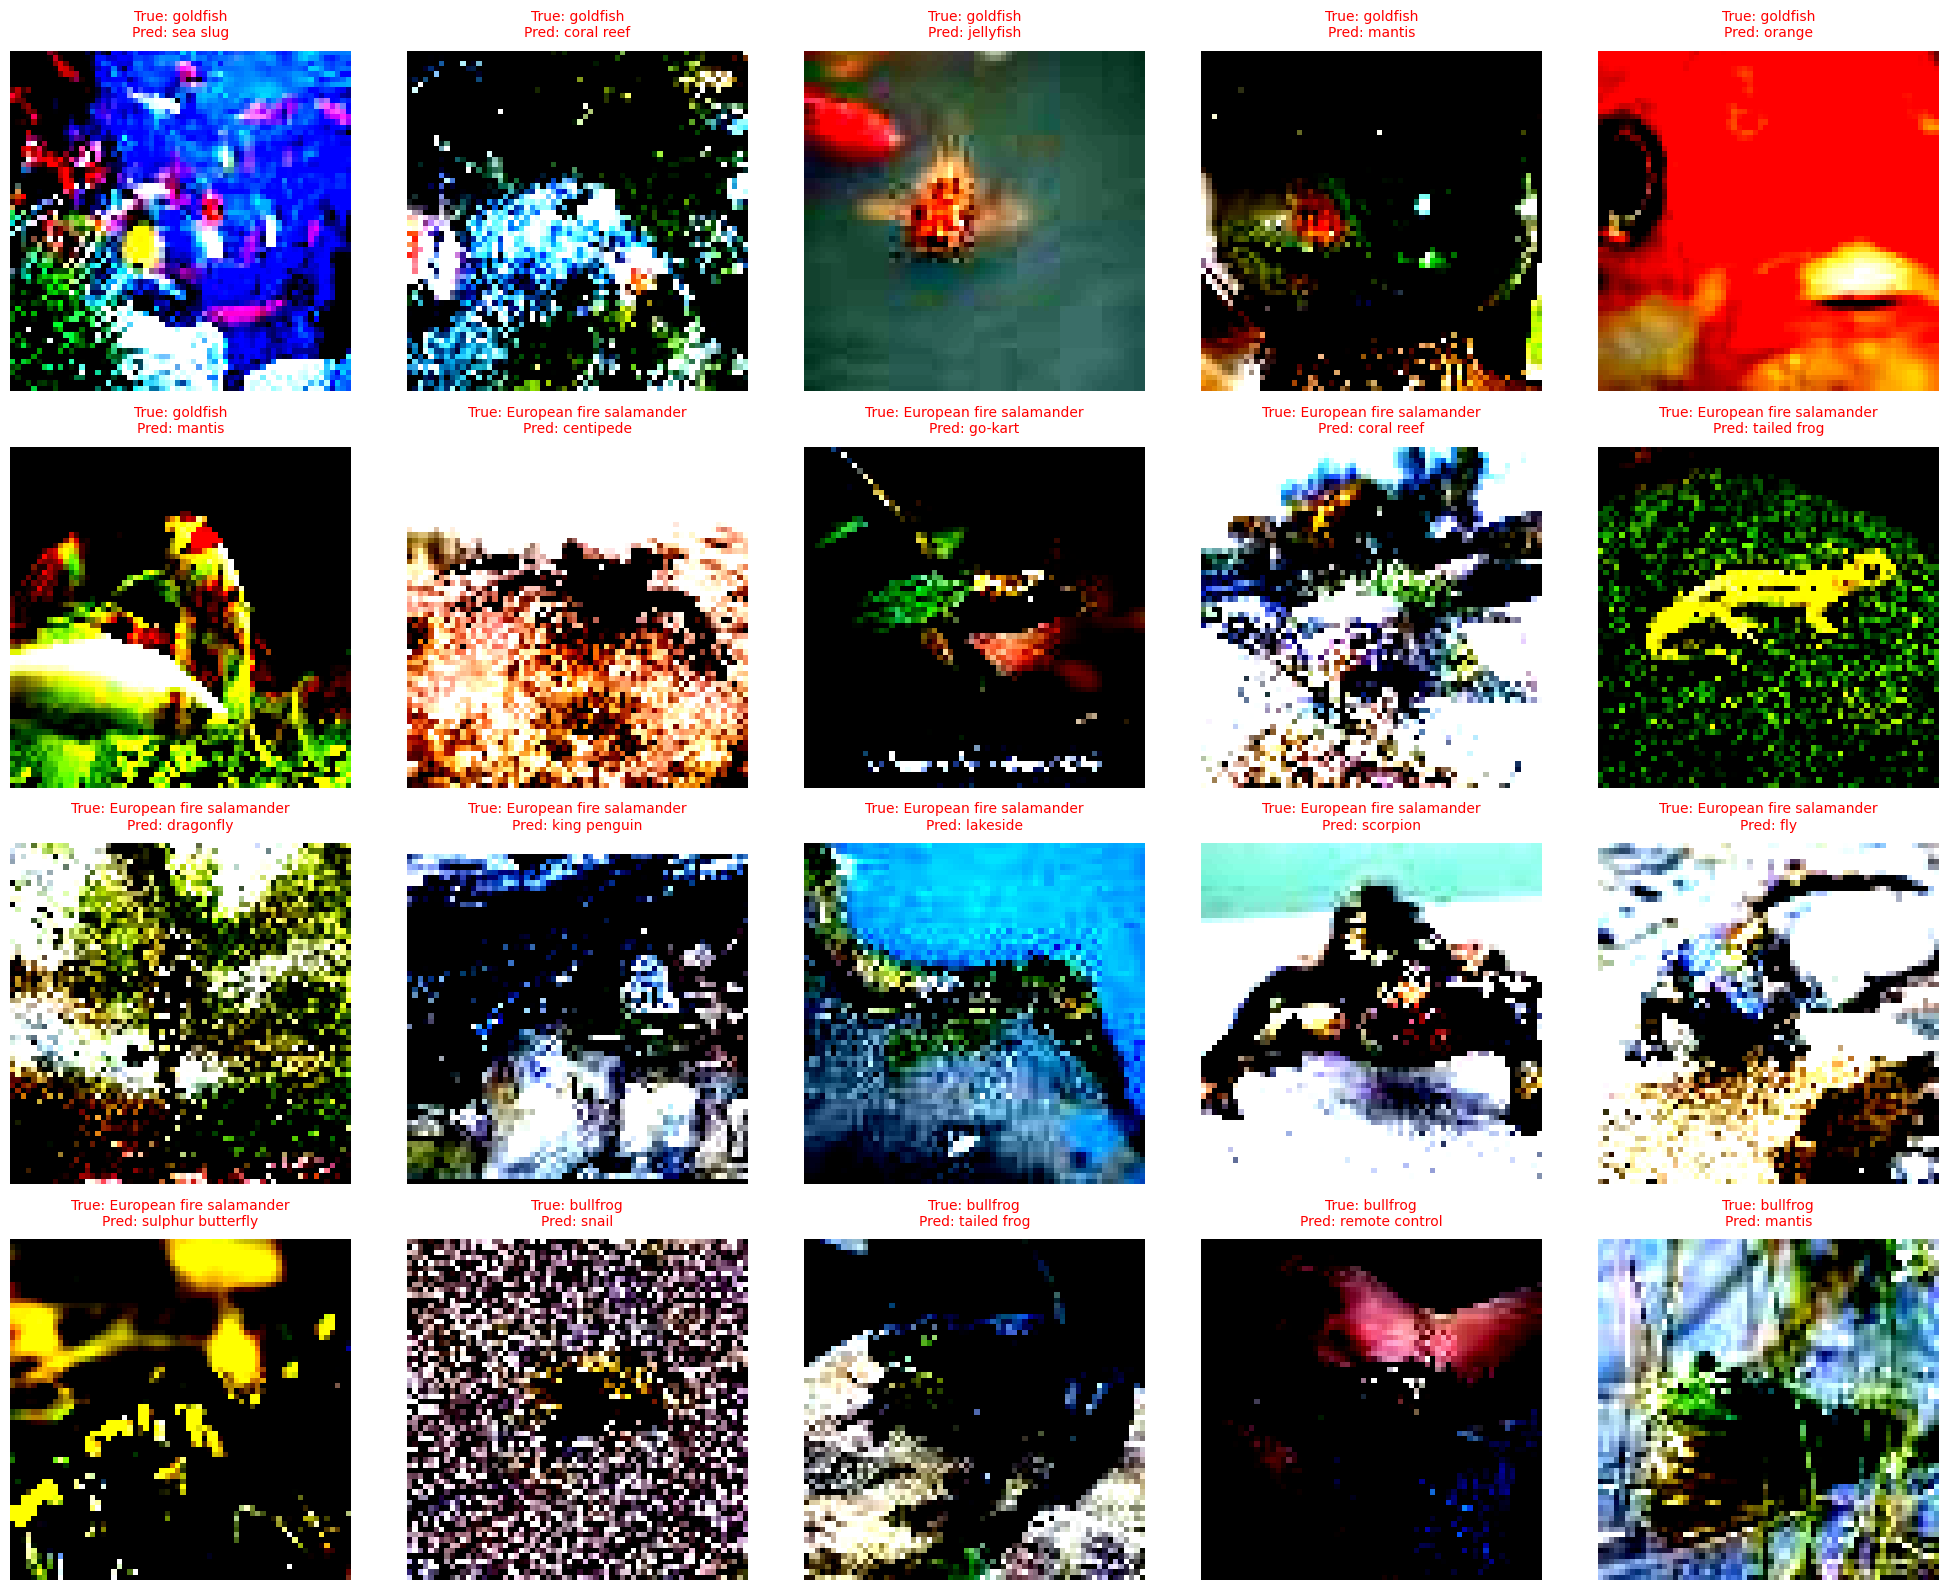

In [28]:
# Plot misclassified images
plot_misclassified(misclassified_images, true_classes, pred_classes)

In [29]:
# Print model accuracy
print("\nEvaluating model on validation set...")
model.eval()
correct = 0
total = 0
class_correct = {}
class_total = {}

with torch.no_grad():
    for images, labels in tqdm(val_loader):
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
        
        # Per-class accuracy
        for label, pred in zip(labels, predicted):
            label_name = class_mapping[train_dataset.classes[label.item()]]
            if label_name not in class_total:
                class_total[label_name] = 0
                class_correct[label_name] = 0
            class_total[label_name] += 1
            if label == pred:
                class_correct[label_name] += 1
                
# Overall accuracy
accuracy = 100 * correct / total
print(f"\nOverall Model Accuracy: {accuracy:.2f}%")

# Print per-class accuracy
print("\nPer-class Accuracy:")
accuracies = []
for class_name in class_total:
    class_acc = 100 * class_correct[class_name] / class_total[class_name]
    accuracies.append((class_name, class_acc))

# Sort by accuracy
accuracies.sort(key=lambda x: x[1], reverse=True)

# Print top 10 and bottom 10 classes
print("\nTop 10 Best Performing Classes:")
for class_name, acc in accuracies[:10]:
    print(f"{class_name[:40]:<40}: {acc:.2f}%")

print("\nBottom 10 Worst Performing Classes:")
for class_name, acc in accuracies[-10:]:
    print(f"{class_name[:40]:<40}: {acc:.2f}%")

# Analyze misclassifications
print("\nMost Common Misclassifications:")
misclass_count = {}
for true_class, pred_class in zip(true_classes, pred_classes):
    if true_class not in misclass_count:
        misclass_count[true_class] = {}
    if pred_class not in misclass_count[true_class]:
        misclass_count[true_class][pred_class] = 0
    misclass_count[true_class][pred_class] += 1

for true_class in misclass_count:
    print(f"\nTrue class: {true_class}")
    sorted_misclass = sorted(misclass_count[true_class].items(), 
                            key=lambda x: x[1], 
                            reverse=True)
    for pred_class, count in sorted_misclass[:3]:
        print(f"  Predicted as {pred_class}: {count} times")


Evaluating model on validation set...


100%|██████████| 79/79 [00:03<00:00, 21.90it/s]


Overall Model Accuracy: 49.80%

Per-class Accuracy:

Top 10 Best Performing Classes:
goldfish                                : 88.00%
sulphur butterfly                       : 86.00%
dugong                                  : 84.00%
bullet train                            : 84.00%
school bus                              : 84.00%
monarch                                 : 82.00%
triumphal arch                          : 82.00%
European fire salamander                : 80.00%
espresso                                : 80.00%
jellyfish                               : 78.00%

Bottom 10 Worst Performing Classes:
reel                                    : 20.00%
drumstick                               : 18.00%
lakeside                                : 18.00%
bucket                                  : 16.00%
chain                                   : 16.00%
pole                                    : 16.00%
syringe                                 : 16.00%
umbrella                                : 14

## ChatGPT

If switching to **Adam** from **SGD** led to overfitting quickly and caused the **validation accuracy to drop** (even if it stabilized at around 65%), it suggests that Adam may be too aggressive in terms of how it adapts the learning rate, especially for a small dataset. Adam's adaptive nature can sometimes lead to faster overfitting, especially if your model is complex relative to the dataset size.

In this case, experimenting with different optimizers or optimizer configurations could help improve your model's generalization and prevent overfitting. Below are some alternatives that might be more effective in your situation:

### **1. RMSprop (Root Mean Squared Propagation):**
   - **Why it might help**: RMSprop is an adaptive learning rate method like Adam but uses a moving average of squared gradients to scale the learning rate. It can handle noisy gradients well and is often used for tasks that involve small datasets or noisy data, such as in **image classification** problems.
   - **How to use it**:
     ```python
     from tensorflow.keras.optimizers import RMSprop
     optimizer = RMSprop(learning_rate=0.001, rho=0.9, epsilon=1e-07)
     model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])
     ```
     - **Tuning the `rho`**: You might also want to experiment with the `rho` parameter (decay factor). Lower values of `rho` give more weight to the most recent gradients, which can help prevent overfitting in some cases.

### **2. Nadam (Nesterov-accelerated Adaptive Moment Estimation):**
   - **Why it might help**: Nadam is a variant of Adam that incorporates **Nesterov momentum**. It combines the benefits of momentum and adaptive learning rates, which can help achieve faster convergence and sometimes improve generalization compared to Adam, especially on smaller datasets.
   - **How to use it**:
     ```python
     from tensorflow.keras.optimizers import Nadam
     optimizer = Nadam(learning_rate=0.001)
     model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])
     ```

### **3. SGD with Momentum:**
   - **Why it might help**: If you prefer using **SGD**, you can try it with **momentum** to allow the model to maintain smooth updates, reducing the oscillation that occurs with plain SGD and speeding up convergence. Momentum helps accelerate the gradients in the relevant direction and dampens oscillations.
   - **How to use it**:
     ```python
     from tensorflow.keras.optimizers import SGD
     optimizer = SGD(learning_rate=0.01, momentum=0.9, nesterov=True)
     model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])
     ```
     - **Nesterov momentum** allows you to get a slight boost in convergence by looking ahead to the future gradient direction.

### **4. Adagrad (Adaptive Gradient Algorithm):**
   - **Why it might help**: Adagrad adjusts the learning rate for each parameter based on the historical gradient information, making it effective for sparse data and scenarios where some features are more important than others.
   - **How it might help in your case**: This optimizer adapts well to small datasets because it can decrease the learning rate rapidly once it has saturated and adjusts based on individual parameter needs.
   - **How to use it**:
     ```python
     from tensorflow.keras.optimizers import Adagrad
     optimizer = Adagrad(learning_rate=0.01)
     model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])
     ```

### **5. Look-ahead Optimizer (if using TensorFlow 2.x or Keras):**
   - **Why it might help**: The **Lookahead Optimizer** works by performing several small steps using an inner optimizer (like SGD or Adam), and then "looking ahead" by updating the weights only when there is a consistent direction for several steps. This approach can help stabilize training and improve generalization.
   - **How to use it**: This optimizer requires a bit more effort to implement, as it is not built into the core libraries, but it can be beneficial if you’ve already tried other approaches.

### **Things to Try to Prevent Overfitting:**

In addition to trying different optimizers, here are a few other strategies to reduce overfitting and improve generalization:

1. **Regularization**:
   - Add **L2 weight decay** or **dropout** layers to prevent overfitting, as you may be training a model that is too complex for your data.
     - Example of dropout:
       ```python
       from tensorflow.keras.layers import Dropout
       model.add(Dropout(0.5))
       ```
   
2. **Early Stopping**:
   - Stop training as soon as validation accuracy starts to degrade. This prevents overfitting and ensures the model is not learning patterns that are too specific to the training data.
     ```python
     from tensorflow.keras.callbacks import EarlyStopping
     early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
     model.fit(..., callbacks=[early_stopping])
     ```

3. **Data Augmentation**:
   - If you haven’t done so already, apply **data augmentation** to artificially expand your training dataset by transforming images (e.g., rotations, flips, zooms).
     ```python
     from tensorflow.keras.preprocessing.image import ImageDataGenerator
     datagen = ImageDataGenerator(rotation_range=40, width_shift_range=0.2, height_shift_range=0.2, 
                                  shear_range=0.2, zoom_range=0.2, horizontal_flip=True, fill_mode='nearest')
     datagen.fit(X_train)
     model.fit(datagen.flow(X_train, Y_train, batch_size=32), ...)
     ```

4. **Reduce Model Complexity**:
   - If the model is too complex relative to the dataset size, try reducing its complexity (e.g., using fewer layers or fewer parameters in the layers).

5. **Fine-tuning a Pre-trained Model**:
   - Use transfer learning with a pre-trained model like **ResNet**, **Inception**, or **VGG**, and fine-tune the top layers to avoid overfitting and leverage knowledge learned from a large dataset like ImageNet.

### **Conclusion:**
If **Adam** caused overfitting, it may be too aggressive for your specific case. **RMSprop** and **Nadam** are good alternatives that maintain the benefits of adaptive learning rates while being less prone to overfitting. If you're looking for a more traditional approach, **SGD with momentum** is still a strong option. Don't forget to combine these optimizers with strategies like **regularization**, **early stopping**, **data augmentation**, and **transfer learning** to improve your model's generalization capabilities.